In this lecture we will build a Recurrent NN (RNN), we will use a names dataset.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import glob
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

Let us import the data for the names and their languages. 

In [2]:
all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Irish.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
# a-z + A-Z + ' .,;'
n_letters = len(all_letters)
learning_rate = 0.005
n_epochs = 200000

We will turn the Unicode string in the text files to plain ASCII

In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

Build the category_lines dictionary, a list of names per language

In [5]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(all_categories)
print('n_categories =', n_categories)

['English', 'Arabic', 'Russian', 'Czech', 'Korean', 'Spanish', 'Greek', 'French', 'Portuguese', 'Scottish', 'Japanese', 'Vietnamese', 'Polish', 'Chinese', 'Italian', 'German', 'Dutch', 'Irish']
n_categories = 18


Turn a word into an array of 1-hot encoded vector of $word\ length \times1\times number\ of\ letters$.

In [6]:
def name_to_tensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

print(name_to_tensor('James').size())

torch.Size([5, 1, 57])


In [7]:
def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(name_to_tensor(line))
    return category, line, category_tensor, line_tensor

In [8]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

Below is the architecture of the neural network we shall design i.e a Recurrent Neural Network

<img src="https://camo.githubusercontent.com/f8a843661e448e1a75f8319a2eea860ebf09794f/68747470733a2f2f692e696d6775722e636f6d2f5a32786279534f2e706e67">

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

Congratulations on creating your first RNN model. Go ahead and experiment with the __learning rate__ and __number of epochs__ once you are done to understand how they affect your model's performance.

Here we pass each word as a $2D$ 1-hot encoded array of size $length\times56$. Go ahead and try another approach.

In [10]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Now that we have our model we need to decide what loss function we want to use and the optimizer that will minimize our loss function. 

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

We will also create an optimizer which updates the parameters of our model according to its gradients. We will use the vanilla SGD algorithm with a low learning rate.

In [11]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

We now train the data i.e. we iterate over the test data and pass it to the model. We calculate loss, backpropagate and then try to optimize our loss function.

A common practice while training is to print the status, plot the loss function or show the value of the loss after every $n$ steps. Here we choose to plot every $10000$ iterations and include in the plot every $1000$ steps. After every $10000$ epochs we also test our model randomly on a word/name.

Let us get an estimate of how long this process takes using the $time$ package.

In [12]:
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    # output, loss = train(category_tensor, line_tensor)
    
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    current_loss += loss.data[0]
    
    # Print epoch number, loss, name and guess along with right or wrong
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d Progress:%d%% (Time:%s) Loss:%.4f Prediction:%s / Label:%s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/hemant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10000 Progress:5% (Time:0m 8s) Loss:3.2358 Prediction:Munro / Label:Portuguese ✗ (Scottish)
20000 Progress:10% (Time:0m 17s) Loss:1.1386 Prediction:Chi / Label:Chinese ✗ (Korean)
30000 Progress:15% (Time:0m 25s) Loss:1.2842 Prediction:Zientek / Label:Polish ✓
40000 Progress:20% (Time:0m 34s) Loss:3.5095 Prediction:Salomon / Label:French ✗ (Italian)
50000 Progress:25% (Time:0m 43s) Loss:0.2265 Prediction:Inihara / Label:Japanese ✓
60000 Progress:30% (Time:0m 51s) Loss:1.4376 Prediction:Fonseca / Label:Portuguese ✗ (Spanish)
70000 Progress:35% (Time:1m 0s) Loss:0.0819 Prediction:Limanov / Label:Russian ✓
80000 Progress:40% (Time:1m 8s) Loss:1.8666 Prediction:Dubhan / Label:Vietnamese ✗ (Irish)
90000 Progress:45% (Time:1m 16s) Loss:0.8935 Prediction:Ding / Label:Vietnamese ✗ (Chinese)
100000 Progress:50% (Time:1m 24s) Loss:0.5708 Prediction:Ferro / Label:Portuguese ✓
110000 Progress:55% (Time:1m 32s) Loss:0.0238 Prediction:Najjar / Label:Arabic ✓
120000 Progress:60% (Time:1m 40s) Loss:2.5

After 200000 epochs we get a loss of $1.58$ and the overall training time was $162$ seconds. 

Note: Total number of iterations = size_of_dataset / batch_size 

Congratualtions on training your first model with an image dataset. No go ahead and test the model's performance and repeat this process after changing the hyperparameters.

/home/hemant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


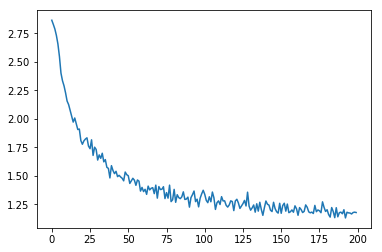

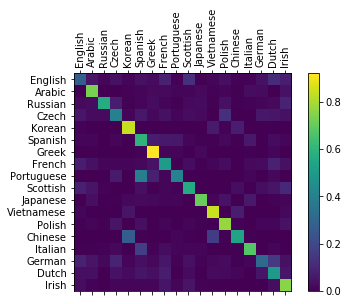

Accuracy of the network on the 10000 test words: 60 %


In [13]:
plt.figure()
plt.plot(all_losses)# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
correct = 0

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    correct += (category_i == guess_i)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

print('Accuracy of the network on the 10000 test words: %d %%' % (100 * correct / n_confusion))

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(name_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

You can test your model with custom inputs using the $predict()$:

In [15]:
predict('Vladamir')
predict('Jesus')
predict('Leonardo')
predict('Omar')
predict('Fernando')
predict('Lamar')
predict('Tyrone')
predict('Wolfgang')


> Vladamir
(-0.99) French
(-1.66) Czech
(-2.22) German

> Jesus
(-1.54) Portuguese
(-2.11) Scottish
(-2.12) Arabic

> Leonardo
(-0.52) Spanish
(-1.29) Italian
(-3.00) French

> Omar
(-1.20) German
(-1.63) French
(-1.92) Arabic

> Fernando
(-0.91) Spanish
(-1.07) Italian
(-2.08) Portuguese

> Lamar
(-1.42) Czech
(-1.42) German
(-1.46) French

> Tyrone
(-0.64) Irish
(-1.71) English
(-2.34) Vietnamese

> Wolfgang
(-1.16) English
(-1.62) Italian
(-1.68) German


/home/hemant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


When you are finally satisfied with your results you can even save your model for future use as below.

In [16]:
torch.save(rnn.state_dict(), 'names_rnn.pkl')